# MICrONS NWB co-registration and visualization

This notebook uses the `dandi`-hosted [MICrONS functional data](https://dandiarchive.org/dandiset/000402/draft) and `bossdb`-hosted [MICrONS structural data](https://bossdb.org/microns/minnie) to examine and visualize the co-registered cells.


In [13]:
from dandi.dandiapi import DandiAPIClient
from caveclient import CAVEclient
from cloudvolume import CloudVolume

from fsspec.implementations.cached import CachingFileSystem
from fsspec import filesystem
from h5py import File
from pynwb import NWBHDF5IO
from pynwb.file import NWBFile

from tqdm import tqdm
import pandas as pd

from pynwb.ophys import PlaneSegmentation
import matplotlib.pyplot as plt
import pynapple as nap


In [2]:
cave = CAVEclient("minnie65_phase3_v1")

In [3]:
dandiset_id = "000402"
session_no = 7
scan_no = 4
file_path = f"sub-17797/sub-17797_ses-{session_no}-scan-{scan_no}_behavior+image+ophys.nwb"

# Get the location of the file on DANDI
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(file_path)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

In [4]:
# first, create a virtual filesystem based on the http protocol
fs = filesystem("http")

# create a cache to save downloaded data to disk (optional)
fs = CachingFileSystem(
    fs=fs,
    cache_storage="nwb-cache",  # Local folder for the cache
)

# next, open the file
file_system = fs.open(s3_url, "rb")
file = File(file_system, mode="r")

# Open the file with NWBHDF5IO
io = NWBHDF5IO(file=file, load_namespaces=True)

microns_data = io.read()

/Users/goodehm1/miniconda3/envs/nwb/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.1 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/goodehm1/miniconda3/envs/nwb/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/goodehm1/miniconda3/envs/nwb/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.2.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [5]:
def create_new_plane_segmentation(old, df, descriptions):
    ps = PlaneSegmentation(
        name=old.name, 
        description=old.description, 
        imaging_plane=old.imaging_plane,
        id=df.index.tolist()
    )
    
    for col in df.columns:
        if col in old.colnames:
            old_col = find_column_by_name(old, col)
            ps.add_column(name=old_col.name, description=old_col.description, data=df[col].tolist())
        else:
            ps.add_column(name=col, description=descriptions[col], data=df[col].tolist())
    return ps
        

def find_column_by_name(table,col_name):
    for c in table.columns:
        if c.name == col_name:
            return c

In [6]:
def update_microns_nwb_file(
    nwb: NWBFile,
    coregistration_table="apl_functional_coreg_forward_v5",
    scan_unit_path="./ScanUnit.pkl",
    add_scan_units_to_nwb=True,
    used_cache_coregistration_table=False,
    cache_coregistration_table_path= "./apl_functional_coreg_forward_v5.pkl",
    
):
    if used_cache_coregistration_table:
        coreg = pd.read_pickle(cache_coregistration_table_path)
    else:
        cave = CAVEclient("minnie65_phase3_v1")
        coreg = cave.materialize.query_table(coregistration_table)
        
    session, scan_idx = int(nwb.session_id.split('-')[0]), int(nwb.session_id.split('-')[2])
    scan_units = pd.read_pickle(scan_unit_path)
    scan_units = scan_units[(scan_units['session']==session) & (scan_units['scan_idx']==scan_idx)]
    
    image_segmentation = nwb.processing["ophys"].data_interfaces["ImageSegmentation"]
    
    all_ps = list(image_segmentation.plane_segmentations)
    for ps_name in tqdm(all_ps):
        
        ps = image_segmentation.plane_segmentations.pop(ps_name)
        field = int(ps_name[-1])
        field_scan_units = scan_units[scan_units['field'] == field]
        ps_df = ps[:]
        ps_df['mask_id'] = ps_df.index
        ps_df_with_units = ps_df.merge(field_scan_units, on='mask_id', how='left').drop(columns=[
            'mask_id', 'session', 'scan_idx', 'field'
        ])
        
        coreg_units = coreg[
            (coreg['session']==session) & 
            (coreg['scan_idx']==scan_idx) & 
            (coreg['field'] == field)
        ][['target_id', 'unit_id']]
        
        if len(coreg_units):
            ps_df_with_units = ps_df_with_units.merge(coreg_units, on='unit_id').rename(
                columns={
                    'target_id': 'auto_match_cave_nuclei_id', 
                    'cave_ids': 'manual_match_cave_nuclei_id'
                }
            )
        
        description = {x: "Placeholder" for x in ps_df_with_units.columns}
        new_ps = create_new_plane_segmentation(ps, ps_df_with_units, description)
        image_segmentation.plane_segmentations.add(new_ps)
        
    return nwb

# TEST EXECUTION

In [7]:
microns_data = update_microns_nwb_file(microns_data, used_cache_coregistration_table=True)

100%|██████████| 8/8 [00:15<00:00,  1.93s/it]


In [8]:
microns_data

root pynwb.file.NWBFile at 0x10986054288
Fields:
  acquisition: {
    EyeTracking <class 'pynwb.behavior.EyeTracking'>,
    PupilTracking <class 'pynwb.behavior.PupilTracking'>,
    TwoPhotonSeries1 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries2 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries3 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries4 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries5 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries6 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries7 <class 'pynwb.ophys.TwoPhotonSeries'>,
    TwoPhotonSeries8 <class 'pynwb.ophys.TwoPhotonSeries'>,
    Video: stimulus_17797_7_4_v4 <class 'pynwb.image.ImageSeries'>,
    treadmill_velocity <class 'pynwb.base.TimeSeries'>
  }
  devices: {
    Microscope <class 'pynwb.device.Device'>
  }
  experiment_description: The light microscopic images were acquired from a cubic millimeter volume that spanned portions of primary visual cortex and three higher visual cortical areas. The volume was imaged in vivo by two-photon random access mesoscope (2P-RAM) from postnatal days P75 to P81 in a male mouse expressing a genetically encoded calcium indicator in excitatory cells, while the mouse viewed natural movies and parametric stimuli. The calcium imaging data includes the single-cell responses of an estimated 75,000 pyramidal cells imaged over a volume of approximately 1200 x 1100 x 500 μm3 (anteroposterior x mediolateral x radial depth). The center of the volume was placed at the junction of primary visual cortex (VISp) and three higher visual areas, lateromedial area (VISlm), rostrolateral area (VISrl) and anterolateral area (VISal). During imaging, the animal was head-restrained, and the stimulus was presented to the left visual field. Treadmill rotation (single axis) and video of the animal's left eye were captured throughout the scan, yielding the locomotion velocity, eye movements, and pupil diameter data included here. The functional data were co-registered with electron microscopy (EM) data. The structural identifiers of the matched cells are added as plane segmentation columns extracted from the CAVE database. To access the latest revision see the notebook that is linked to this dandiset. The structural ids might not be present for all plane segmentations.
  file_create_date: [datetime.datetime(2023, 2, 13, 11, 47, 25, 63376, tzinfo=tzutc())]
  identifier: 4032004d-8ebd-42ab-9da1-e463a602ff00
  imaging_planes: {
    ImagingPlane1 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane2 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane3 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane4 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane5 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane6 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane7 <class 'pynwb.ophys.ImagingPlane'>,
    ImagingPlane8 <class 'pynwb.ophys.ImagingPlane'>
  }
  intervals: {
    Clip <class 'pynwb.epoch.TimeIntervals'>,
    Monet2 <class 'pynwb.epoch.TimeIntervals'>,
    Trippy <class 'pynwb.epoch.TimeIntervals'>
  }
  processing: {
    ophys <class 'pynwb.base.ProcessingModule'>
  }
  related_publications: ['https://doi.org/10.1101/2021.07.28.454025']
  session_description: Contains calcium imaging recorded from multiple cortical visual areas and behavioral measurements while a mouse viewed natural movies and parametric stimuli. The structural ids are added as plane segmentation columns from the CAVE database on 2023-02-13. To access the latest revision see the notebook that is linked to the dandiset. The structural ids might not be present for all plane segmentations.
  session_id: 7-scan-4
  session_start_time: 2018-03-07 00:00:00+00:00
  subject: subject pynwb.file.Subject at 0x10985219600
Fields:
  age: P75D/P81D
  sex: M
  species: Mus musculus
  subject_id: 17797

  timestamps_reference_time: 2018-03-07 00:00:00+00:00

In [40]:
def get_time_series_data(unit_id):
    mask_id = 0
    for plane_seg in range(1, 9):
        image_seg = microns_data.processing["ophys"].data_interfaces["ImageSegmentation"].plane_segmentations[f"PlaneSegmentation{plane_seg}"]
        try:
            mask_id = image_seg.get("unit_id").data.index(unit_id)
        except:
            continue
        else:
            break

    if mask_id == 0:
        return Exception(f"Unit Id {unit_id} not found")

    # Get fluorescence of the table number
    fluor = microns_data.processing["ophys"].data_interfaces["Fluorescence"].roi_response_series[f"RoiResponseSeries{plane_seg}"]

    # Pull the data we are interested in
    mask_image = image_seg.image_mask[mask_id]
    fluor_data = fluor.data[:, mask_id]
    timestamps = fluor.timestamps[:]

    return mask_image, fluor_data, timestamps

Text(0, 0.5, 'response magnitude')

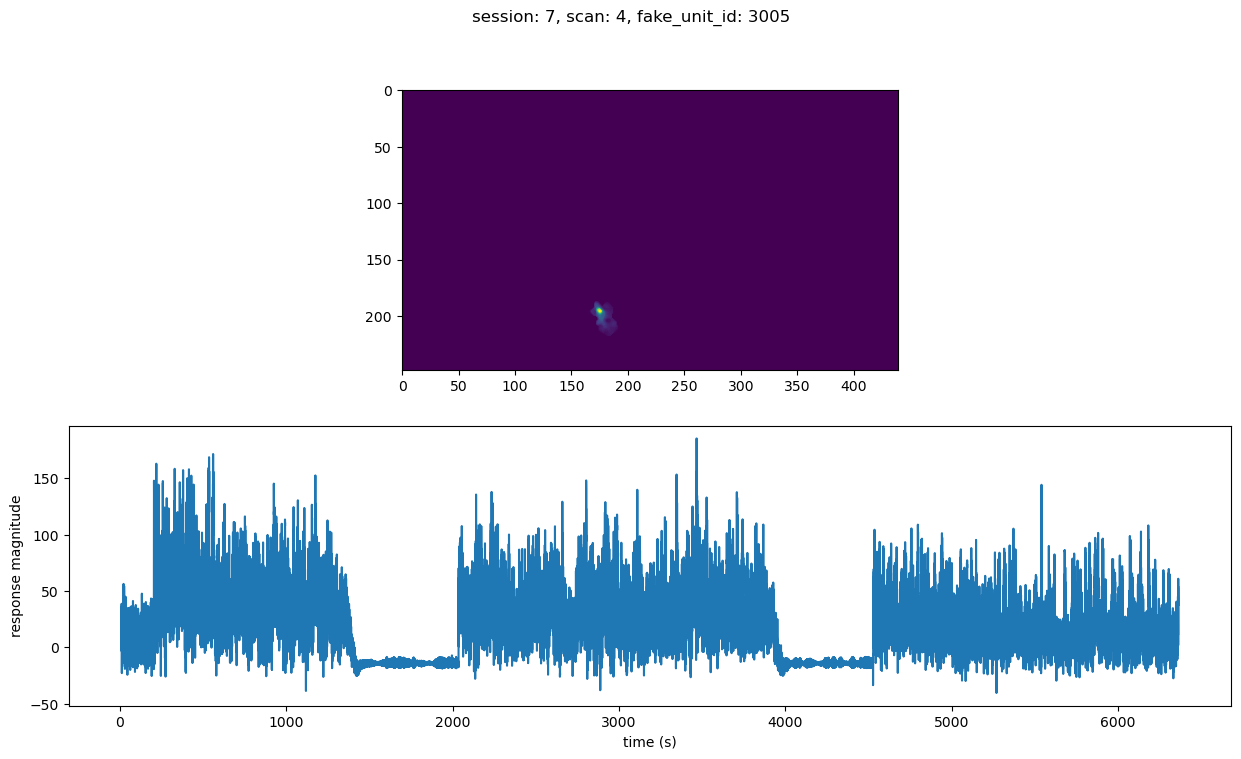

In [43]:
unit_id = 3005
mask_image, fluor, timestamps = get_time_series_data(unit_id)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
fig.suptitle(f'session: {session_no}, scan: {scan_no}, fake_unit_id: {unit_id}')
ax1.imshow(mask_image)
ax2.plot(timestamps, fluor)
ax2.set_xlabel("time (s)")
ax2.set_ylabel("response magnitude")

In [39]:
# pynapple time series analysis

microns_nap = nap.NWBFile(microns_data)
microns_nap_fluor1 = microns_nap['RoiResponseSeries1']

# separate the stimulus videos into correct format
microns_clips = microns_nap["Clip"]
microns_clips_dict = dict(zip(microns_clips.movie_name, [nap.IntervalSet(s,e) for s, e in zip(microns_clips.start_time, microns_clips.stop_time)]))

# this aint gon work
nap.compute_discrete_tuning_curves(group=microns_nap_fluor1, dict_ep=microns_clips_dict)


/Users/goodehm1/miniconda3/envs/nwb/lib/python3.11/site-packages/pynapple/io/interface_nwb.py:376: UserWarning: Too many metadata. Returning pandas.DataFrame, not IntervalSet
  data = self._f_eval[self.data[key]["type"]](obj)


RuntimeError: Unknown format for group